In [37]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
#plt.rc('text', usetex=True)

# Data

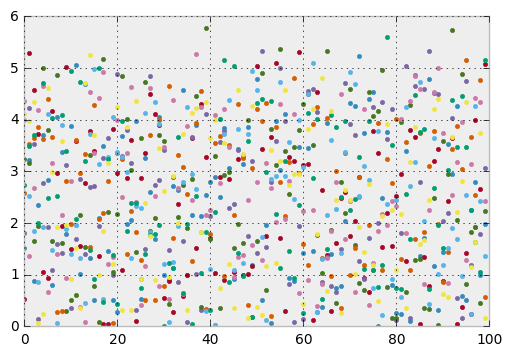

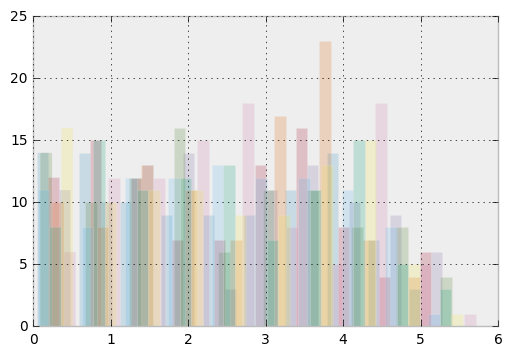

In [38]:
x = np.arange(100)
n = 3
y_mean = .5
y_std = 2
y_scale = y_mean**2/y_std
y_shape = y_std/y_mean
y = np.random.gamma(scale=y_scale, shape=y_shape, size=(len(x),n,n)) + 4
y = y + np.array([np.random.random(size=(n,n)) for i in range(len(x))])
y = y * np.array([np.random.random(size=(n,n)) for i in range(len(x))])
for i in range(n):
    plt.plot(x, y[:,:,i], '.')
plt.figure()
bins = 10
for i in range(n):
    _ = plt.hist(y[:,:,i], bins=bins, alpha=.2)

# Model

In [39]:
# a pyMC3 model ..
with pm.Model() as model:
    # starting with uniform distribution
    alpha = pm.Normal('alpha', mu=8, sd=5, shape=(n,n))
    beta = pm.Uniform('beta', lower=0, upper=1, shape=(n,n))
          
    Y = pm.Gamma('Y', alpha=alpha, beta=beta, observed=y)
          
    start = pm.find_MAP()    
    step = pm.NUTS()
    
    trace = pm.sample(200, step, start=start, progressbar=True)

Applied interval-transform to beta and added transformed beta_interval_ to model.
100%|██████████| 200/200 [00:01<00:00, 112.41it/s]


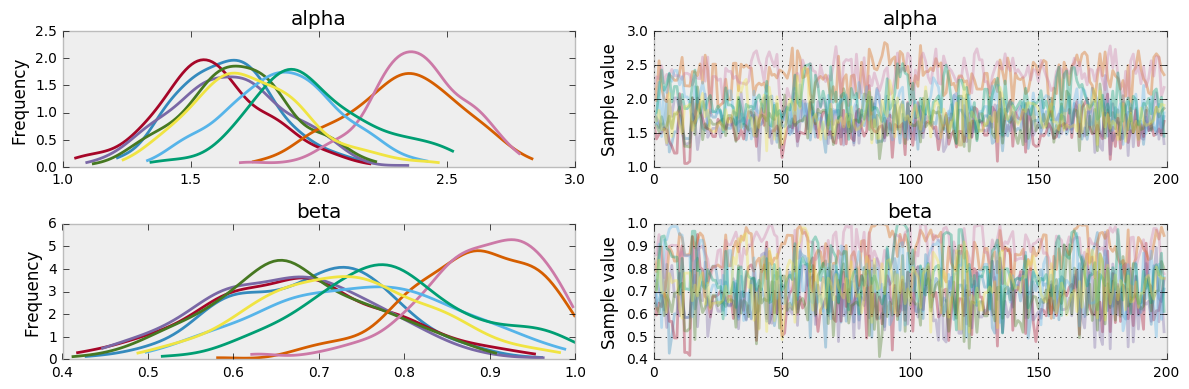

In [40]:
_ = pm.traceplot(trace, 
                 varnames=['alpha', 'beta'])
#_ = pm.autocorrplot(trace, 
#                   varnames=['alpha', 'beta'])

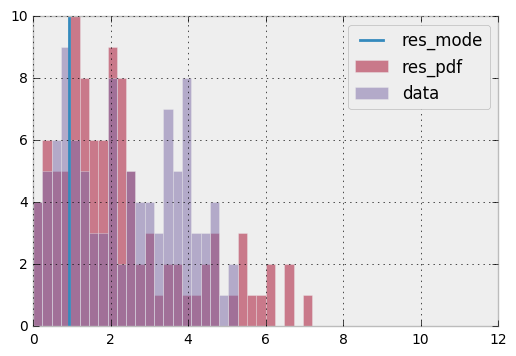

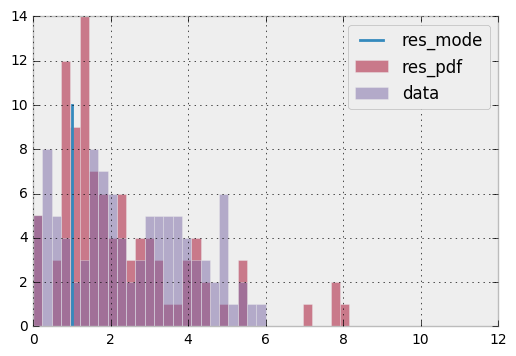

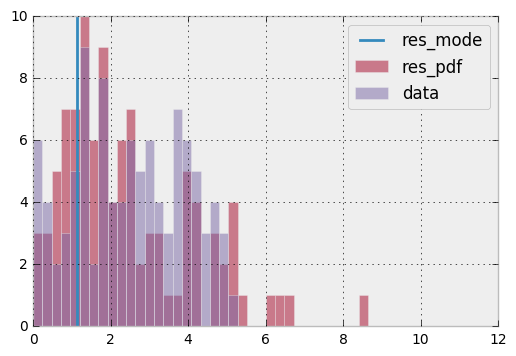

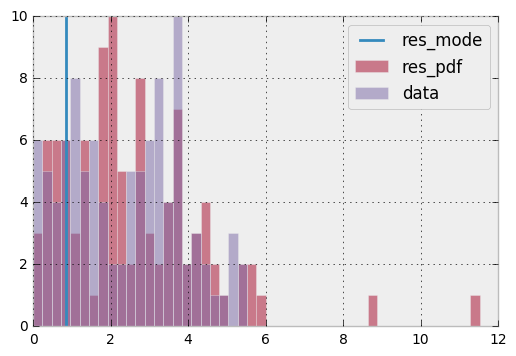

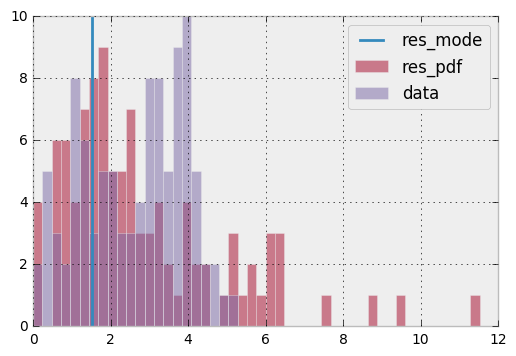

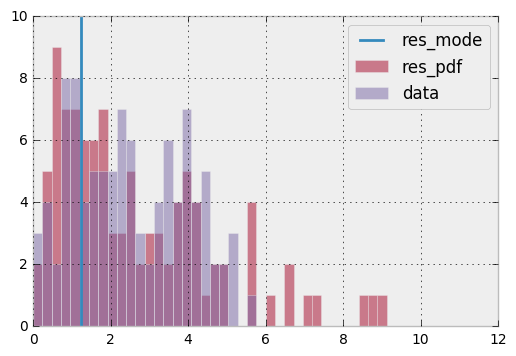

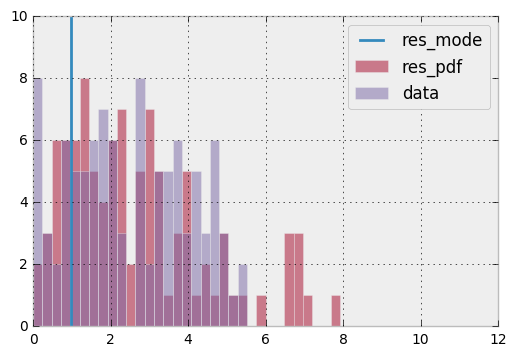

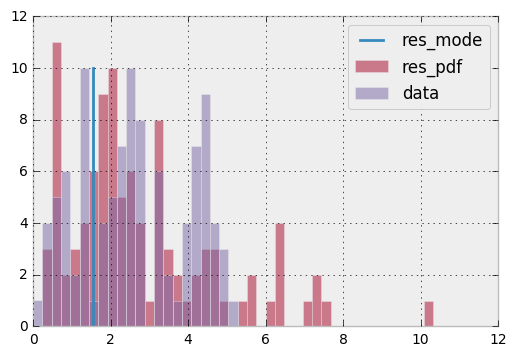

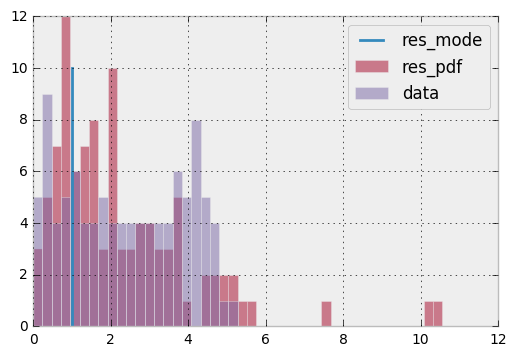

In [48]:
import matplotlib.mlab as mlab
import itertools

alpha_res = trace.get_values('alpha')
beta_res = trace.get_values('beta')

# transformation
# src: https://en.wikipedia.org/wiki/Gamma_distribution
mode = (alpha_res - 1)/beta_res

# shape
k_res = alpha_res
# scale
theta_res = 1/beta_res

assert np.shape(theta_res) == np.shape(beta_res)

burnin = int(.1*len(alpha_res))
bins = 50

for i, j in itertools.product(range(n), repeat=2):
    plt.figure()
    m = np.mean(mode[burnin:,i,j])
    plt.plot([m,m], [10,0])
    res = np.random.gamma(shape=np.mean(k_res[burnin:,i,j]),
                          scale=np.mean(theta_res[burnin:,i,j]),
                          size=len(y[:,0,0]))
    plt.hist(res, bins=bins, range=[0, 12], alpha=.5)  
    # TODO: plot with stats.gamma.pdf
    
    plt.hist(y[:,i,j], bins=bins, range=[0, 12], alpha=.5)
                          
    plt.legend(['res_mode', 'res_pdf', 'data'])